# Stockpile Optimization Model

## Initialize model
#### Import libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import brentq
from __future__ import division
from collections import deque

## Define modeling functions

### Import data and create demand-side distribution

In [ ]:
def import_freq_distrib(file_name):
    
    freq_df = pd.read_excel(file_name,skiprows=5)
    freq_df.drop([freq_df.columns[0]],axis=1,inplace=True)
    freq_df = freq_df.pivot(columns='Year',values='Districts')
    freq_df = np.nan_to_num(freq_df, copy=True)

    freq_distrib = np.count_nonzero(freq_df,axis=0)
    
    freq_df_no_zero = freq_df[freq_df != 0]
    outbreak_districts_distrib = []
    for i in range(len(freq_df_no_zero)):
        outbreak_districts_distrib.append(int(freq_df_no_zero[i]))
    
    return freq_distrib, outbreak_districts_distrib

In [205]:
def import_pop_distrib(file_name):
    pop_data_sheet = pd.ExcelFile(file_name)
    pop_vals = pop_data_sheet.parse().Pop.values
    return pop_vals

In [214]:
# generate cumulative demand distribution
# NOTE -- does not yet include adjustment for pre-existing RI coverage
def create_demand_distrib(freq_distrib,outbreak_districts_distrib,pop_distrib,target_pop,target_cov,dose_num,excess_stock,simulated_years):
    demand_distrib = []
    for year in range(simulated_years):
        annual_demand = []
        freq_val = np.random.choice(freq_distrib)
        for outbreak in range(freq_val):
            district_count = np.random.choice(outbreak_districts_distrib)
            local_pops = []
            for district in range(district_count):
                local_pops.append(np.random.choice(pop_distrib))
            total_local_pop = sum(local_pops)
            local_demand = int(total_local_pop*target_pop*target_cov*dose_num*(1+excess_stock))
            annual_demand.append(local_demand)
        demand_distrib.append(sum(annual_demand))
    
    return demand_distrib

### Import and structure product information; define costs

In [27]:
def import_price_data(price_file_name):
    price_file = pd.ExcelFile(price_file_name)
    product_dataset = []
    product_types = []

    for sheet in price_file.sheet_names:
        product_types.append(str(sheet))
        sheet_data = [str(sheet),price_file.parse(sheet)]
        product_dataset.append(sheet_data)
    
    return product_dataset, product_types

In [28]:
def get_prod_arrays(df):
    buyvols = df.BuyVol.values
    cumbuysums = np.zeros(len(buyvols) + 1)
    cumbuysums[1:] = buyvols.cumsum()
    prices_buy = df.Price.values
    
    sellvols = df.SellVol.values
    cumsellsums = np.zeros(len(buyvols) + 1)
    cumsellsums[1:] = sellvols.cumsum()
    vals_sell = df.Resale.values
    return buyvols, cumbuysums, prices_buy, sellvols, cumsellsums, vals_sell

In [29]:
def prod_array_maker(product_dataset, product_types):
    product_arrays = []
    for prod in range(len(product_types)):
        prod_arr = [0,0,0,0,0,0,0]
        prod_arr[0] = product_dataset[prod][0]
        prod_arr[1],prod_arr[2],prod_arr[3],prod_arr[4],prod_arr[5],prod_arr[6] = get_prod_arrays(product_dataset[prod][1])
        product_arrays.append(prod_arr)
    
    return product_arrays

In [9]:
# returns the total cost of product procurement according to volume-dependent pricing model
def price_vx_buy_func(p_array, desired_volume):
#    assert desired_volume >= 0 , "Negative desired_volume"
#    assert desired_volume <= cumsums[-1], "Total volume exceeded"
    buyvols = p_array[1]
    cumbuysums = p_array[2]
    prices = p_array[3]
    
    i = int(np.searchsorted(cumbuysums[1:], desired_volume))
    cost_buy = np.sum(buyvols[: i] * prices[: i]) + (desired_volume - cumbuysums[i]) * prices[i]
    return cost_buy

# returns weighted average cost per dose
def price_vx_buy_dose(p_array, desired_volume):
    total_cost = price_vx_buy_func(p_array, desired_volume)
    price_vx_dose = total_cost/desired_volume
    return price_vx_dose


# returns the total value of resold doses according to volume-dependent pricing model
def value_vx_resale_func(p_array, desired_volume):
#    assert desired_volume >= 0 , "Negative desired_volume"
#    assert desired_volume <= cumsums[-1], "Total volume exceeded"
    sellvols = p_array[4]
    cumsellsums = p_array[5]
    sellval = p_array[6]
    
    i = int(np.searchsorted(cumsellsums[1:], desired_volume))
    val_resale = np.sum(sellvols[: i] * sellval[: i]) + (desired_volume - cumsellsums[i]) * sellval[i]
    return val_resale

# returns weighted average resale value per dose
def value_vx_resale_dose(p_array, desired_volume):
    total_val = value_vx_resale_func(p_array, desired_volume)
    val_resale_dose = total_val/desired_volume
    return val_resale_dose

### Find optimal switch-point when procuring more than one product type

In [10]:
# returns the probability of using the n-th dose in a stockpile containing n doses over the life of the product
def prob_dose_use(stockpile_size,demand_distrib,shelf_life,samples=10000):
    trues = 0
    for sample in range(samples):
        tests = []
        for year in range(shelf_life):
            tests.append(int(np.random.choice(demand_distrib)))
        sample_sum = sum(tests)
        if sample_sum >= stockpile_size:
            trues += 1
    result = trues / samples
    return result

In [11]:
# returns the expected cost of procurement, accounting for likelihood of use versus wastage/resale
def exp_cost_dose(stockpile_volume,demand_distrib,shelf_life,p_array):
    prob_use = prob_dose_use(stockpile_volume,demand_distrib,shelf_life)
    cost_vx_dose = price_vx_buy_dose(p_array,stockpile_volume)*prob_use + (price_vx_buy_dose(p_array,stockpile_volume)-value_vx_resale_dose(p_array,stockpile_volume))*(1-prob_use)
    return cost_vx_dose

In [12]:
# reduces pricing functions into functions of one variable -- prepares for optimization
# NOTE: hard-coded variables may require revision for each change of disease/ input dataset
def exp_cost_ps(stockpile_volume):
    exp_cost_ps = exp_cost_dose(stockpile_volume,values,shelf_life,product_arrays[0])
    return exp_cost_ps

def exp_cost_conj(stockpile_volume):
    exp_cost_conj = exp_cost_dose(stockpile_volume,values,shelf_life,product_arrays[1])
    return exp_cost_conj

def find_prod_switch_vol(func1,func2,demand):
    try:
        return brentq(lambda x : func1(x)-func2(x),np.min(demand),np.max(demand))
    except ValueError:
        return np.max(demand)

In [13]:
#returns the threshold volume up to which maufacturers require firm commitments
def firm_volume(price_data):
    num_man = int(len(price_data.columns)/7)
    tiers = len(price_data.index)
    firm_vols = []
    
    for man in range(num_man):
        man_vol = 0
        for tier in range(tiers):
            if price_data[price_data.columns[man*5+6]][tier]==1:
                man_vol = man_vol + price_data[price_data.columns[man*6]][tier]
        firm_vols.append(man_vol)
    
    firm_volume = np.sum(firm_vols)
    return firm_volume

In [14]:
def find_perc_cutoff(demand,cutoff_vol):
    perc_cutoff = len(demand[demand<cutoff_vol])/len(demand)
    return perc_cutoff

### Manage inventory

In [15]:
# initialize inventory deque with [shelf-life] number of batches, and [product_types] number of slots per batch
# convention: oldest batch listed on top (slot 0), newest on bottom
# convention: first product to use (PS) listed on left within each batch (slot 0), second product (Conjugate) on right
def inventory_launch(stockpile_size,price_data,shelf_life):
    inventory = deque(['' for year in range(shelf_life)],shelf_life)
    for year in range(shelf_life):
        year_slot = []
        for product in range(len(price_data)):
            prod_name = price_data[product][0]
            prod_slot = [prod_name, 0]
            year_slot.append(prod_slot)
        inventory[year] = year_slot

# assign all initial inventory to newest batch, with split across product types if required
    if len(product_dataset) == 1:
        inventory[shelf_life-1][0][1] = stockpile_size
    elif len(product_dataset) == 2:
        if stockpile_size <= prod_switch_vol:
            inventory[shelf_life-1][0][1] = stockpile_size
        else:
            inventory[shelf_life-1][0][1] = prod_switch_vol
            inventory[shelf_life-1][1][1] = stockpile_size - prod_switch_vol

    return inventory

In [16]:
# deplete inventory by [demand] amount, using FIFO convention
# demand is sampled at random from demand probability distribution
def inventory_use(inventory_list,demand,product_types):
    inventory = inventory_list
    depletion = 0
    total_use_record = []
    
    for product in range(len(product_types)):
        product_use_record = [product_types[product],0]
        for year in range(len(inventory)):
            if inventory[year][product][1] + depletion < demand:
                depletion = depletion + inventory[year][product][1]
                product_use_record[1] = product_use_record[1] + inventory[year][product][1]
                inventory[year][product][1] = 0
            elif inventory[year][product][1] + depletion >= demand:
                product_use_record[1] = product_use_record[1] + (demand-depletion)
                total_use_record.append(product_use_record)
                inventory[year][product][1] = inventory[year][product][1] - (demand-depletion)
                depletion = demand
                break
        if depletion < demand:
            total_use_record.append(product_use_record)
        else:
            break
        
    total_use_vol = 0
    for prod in range(len(total_use_record)):
        total_use_vol = total_use_vol + total_use_record[prod][1]
            
    return inventory, total_use_record, total_use_vol

In [17]:
# clear oldest inventory
def inventory_waste(inventory_list):
    inventory = inventory_list
    if len(inventory) > 0:
        wastage = inventory.popleft()
    else:
        wastage = 0
    
    return inventory, wastage

In [18]:
# return total volume of each product type remaining across all batches
def inventory_status(inventory_list):
    inventory = inventory_list
    prod_num = len(product_types)
    
    status = []
    if len(inventory) > 0:
        for product in range(prod_num):
            name = inventory[0][product][0]
            stock = 0
            for year in range(len(inventory)):
                stock = stock + inventory[year][product][1]
            status.append([name, stock])

        total_stock = 0
        for i in range(len(status)):
            total_stock = total_stock + status[i][1]
    else:
        total_stock = 0
    
    return status, total_stock

In [19]:
# move oldest (top) slot down to bottom, and replenish total volume up to [stockpile_size]
def inventory_replenish(inventory_list,stockpile_size,product_types):
    inventory = inventory_list
    status = inventory_status(inventory)
    current_stock = status[1]
    
    if current_stock < stockpile_size:
        replenish_need = stockpile_size - current_stock
    elif current_stock >= stockpile_size:
        replenish_need = 0
    
    if len(product_types) == 1:
        new_stock = [product_types[0],replenish_need]
    elif len(product_types) == 2:
        if stockpile_size <= prod_switch_vol:
            new_stock = [[product_types[0],replenish_need],[product_types[1],0]]
        elif stockpile_size > prod_switch_vol:
            prod1_gap = prod_switch_vol - status[0][0][1]
            if prod1_gap == 0:
                new_stock = [[product_types[0],0],[product_types[1],replenish_need]]
            elif prod1_gap > 0:
                if replenish_need <= prod1_gap:
                    new_stock = [[product_types[0],replenish_need],[product_types[1],0]]
                elif replenish_need > prod1_gap:
                    new_stock = [[product_types[0],prod1_gap],[product_types[1],replenish_need-prod1_gap]]
    
    inventory.append(new_stock)
    return inventory

### Calculate net-benefit

In [20]:
def net_value_func(demand,inventory,exp_val_vx,price_data,verbose=False):
        
    inventory, use_record, total_use = inventory_use(inventory,demand,product_types)
    total_benefit = total_use*exp_val_vx
    
    cost_of_use = 0
    for prod in range(len(use_record)):
        cost_of_use += price_vx_buy_func(price_data[prod],use_record[prod][1])
    
    inventory, waste_record = inventory_waste(inventory)
    cost_of_waste = 0
    for prod in range(len(waste_record)):
        cost_of_waste += (price_vx_buy_func(price_data[prod],waste_record[prod][1])-value_vx_resale_func(price_data[prod],waste_record[prod][1]))    
    
    total_cost = cost_of_use + cost_of_waste    
    net_val = total_benefit-total_cost
    
    if verbose == True:
        print('  doses used: ', use_record, 'val_life =', exp_val_vx, 'total benefit = ', total_benefit, 'cost of use = ', cost_of_use)
        print('  doses wasted: ', waste_record, 'cost of waste = ', cost_of_waste)
    
    return net_val, inventory

In [21]:
def avg_net_value_across_years(stockpile_size,demand_distrib,exp_val_vx,price_data,product_types,shelf_life,years,verbose=False,dummy=False):
   
    inventory_trckr = inventory_launch(stockpile_size,price_data,shelf_life)
    net_val_total = []
    
    if verbose == True:
        print("initial:", inventory_trckr)
    
    for year in range(years):
        if dummy == False:
            demand = int(np.random.choice(demand_distrib))
        elif dummy == True:
            demand = int(np.random.randint(1,20))
        if verbose == True:
            print(year+1, 'demand:', demand)
            
        yr_net_val, inventory_trckr = net_value_func(demand,inventory_trckr,exp_val_vx,price_data,verbose)
        net_val_total.append(yr_net_val)
        if verbose == True:
            print('  net value:', yr_net_val)
            print('  use + waste:', inventory_trckr)
            print('')
        
        inventory_trckr = inventory_replenish(inventory_trckr,stockpile_size,product_types)
        if verbose == True:
            print('  replenished:', inventory_trckr)
            
    avg_net_val = np.mean(net_val_total)
    return avg_net_val

In [22]:
def neg_avg_net_value_across_years(stockpile_size,demand_distrib,exp_val_vx,price_data,product_types,shelf_life,years):
    neg_avg_net_val = -1*avg_net_value_across_years(stockpile_size,demand_distrib,exp_val_vx,price_data,product_types,shelf_life,years)
    return neg_avg_net_val

In [218]:
def recommendation_func():
    
    # WIP -- TO BE COMPLETED
    
    recommend_stockpile = []
    return recommend_stockpile

### Plot final distribution

In [23]:
def final_plot(demand_distrib, vol_cutoff, perc_cutoff, bins=100, figsize=(10,5)):
    total_mean = np.mean(demand_distrib)
    
    _, ax = plt.subplots(1,1, figsize=figsize)
    min_, max_ = np.min(demand_distrib), np.max(demand_distrib)
    bar_width = (max_ - min_) / bins
    hist, edges = np.histogram(demand_distrib, bins = np.linspace(min_, max_, bins))
    
    idx = edges[:-1] < vol_cutoff
    ax.bar(edges[:-1][idx], height=hist[idx], 
           width=bar_width,
           label='Demand below optimal cutoff', color='green')


    idx =  edges[:-1] >= vol_cutoff
    ax.bar(edges[:-1][idx], height=hist[idx], 
           width=bar_width,
           label='Demand above optimal cutoff', color='blue')
    
    ax.vlines(x=total_mean, ymin=0, ymax=ax.get_ybound()[1], linestyles='dashed', 
              label='Expected value = %.1f' % total_mean)
    ax.vlines(x=vol_cutoff, ymin=0, ymax=ax.get_ybound()[1], linestyles='dashed', 
              label='Cutoff volume = %.1f, Perc = %.1f' % (vol_cutoff,perc_cutoff*100), color='red')
    
    ax.legend();

## Run the model

#### Define global variables

In [193]:
# probability of infection during outbreak
infection_prob = 0.005
# mortality
mort_prob = 0.10
# average years lost if infection fatal
mort_dalys = 35
# morbidity effect of infection (in DALYs lost)
morb_dalys = 1
# average DALYs lost per infection
case_dalys = mort_prob*mort_dalys + (1-mort_prob)*morb_dalys

# gdp per capita
gdp_per_cap = 400
# value per full DALY saved
cost_daly = 3 * gdp_per_cap

# expected value created by delivering one vaccination
exp_val_vx = infection_prob*case_dalys*cost_daly

# target population for vaccination -- as share of total population
target_pop = 0.65
# target coverage rate following vaccination campaign
target_cov = 0.95
# number of doses required per target individual
dose_num = 1
# rate of allowance for wastage and buffer stock -- as share of required doses
excess_stock = 0.2

# specified method for Minimization function
opt_method = 'Nelder-Mead'

In [194]:
disease = 'Meningitis'
simulated_years=100000

In [197]:
freq_file_name = 'Sample_Outbreak_Data.xlsx'
pop_file_name = 'Sample_Pop_Data.xlsx'
RI_cov_file_name = ''
price_file_name = 'MNG_Price_Matrix_Sample.xlsx'

shelf_life = 2

In [215]:
freq_distrib, outbreak_districts_distrib = import_freq_distrib(freq_file_name)
pop_distrib = import_pop_distrib(pop_file_name)
#RI_cov_dist = import_RI_distrib(RI_cov_file_name)

demand_distrib = create_demand_distrib(freq_distrib,outbreak_districts_distrib,pop_distrib,target_pop,target_cov,dose_num,excess_stock,simulated_years)

In [31]:
product_dataset, product_types = import_price_data(price_file_name)
product_arrays = prod_array_maker(product_dataset, product_types)

In [32]:
prod_switch_vol = int(find_prod_switch_vol(exp_cost_conj,exp_cost_ps,demand_distrib))
prod_switch_perc = find_perc_cutoff(demand_distrib,prod_switch_vol)
min_commitments = [[product_dataset[product][0], firm_volume(product_dataset[product][1])] for product in range(len(product_dataset))]

In [ ]:
result = minimize(neg_avg_net_value_across_years,3200000,args=(demand_distrib,exp_val_vx,product_arrays,product_types,shelf_life,5000),method=opt_method,tol=1e-8)
cutoff_vol = result.x[0]
cutoff_perc = find_perc_cutoff(demand_distrib,cutoff_vol)

optimal_stockpile = recommendation_func()

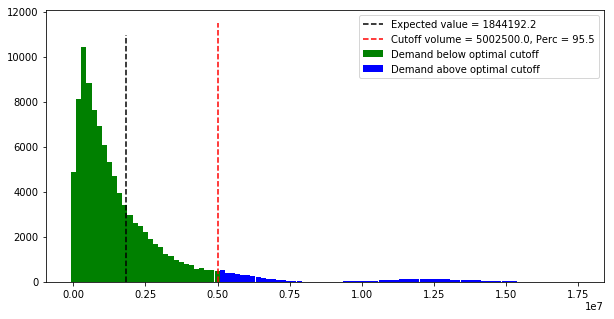

In [208]:
final_plot(demand_dist, cutoff_vol, cutoff_perc)

In [ ]:
percentiles = [50,75,90,95,99]
demand_results = [int(np.percentile(demand_distrib,perc)) for perc in percentiles]

stockpile_results = [disease, cutoff_vol, cutoff_perc, optimal_stockpile]